## Once your model has been trained and exported, import it in this notebook in order to test their predictions





In [14]:
#Here we assume that the model is in the same Directory as this notebook
#Change the value of this variable to test the desired model (classical model is used by default)
model_name = 'classical_model.h5'

In [15]:
#Use a trained model to predict Breast Cancer
#Make sure that the parent folder of Initial Model is within the same directory as the Data Folder with all the images
"""
Example:
+ Data
+ DashApp
  |--- Model
        |--- model_prediction.ipynb
"""
#Comment this to use GPU
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Remove this line if you have a GPU device

## Import and Prepare the Data

In [16]:
import os
#Global variables
DATA_PATH = os.path.join("..","..","Data")
RANDOM_SEED = 42
TEST_FRACTION = 0.2 # Just for initial test it must be something like 0.2
VALIDATION_FRACTION = 0.2 # Use the 20% of the non test samples to build the validation set (the remaining is the Test Set)
# Input patches are 50X50
IMAGE_WIDTH = 50 
IMAGE_LENGTH = 50

In [17]:
import numpy as np
np.random.seed(RANDOM_SEED)
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
import pandas as pd
from sklearn.model_selection import train_test_split
import glob

In [18]:
# read all patches
patches = []
for path in glob.glob(os.path.join(DATA_PATH,'**/*class*.png'), recursive = True):
    patches.append(path)

In [19]:
def createDataFrame():
    # Keep info within a Pandas dataframe
    data = pd.DataFrame({"path" : patches})
    # Obtain patient information by spliting the filename
    series_info = data["path"].str.split("idx").str[1].str.split("_")
    data['id'] = series_info.str[0] # this get the idx portion
    data['x'] = series_info.str[1].str[1:] # this get the x coord
    data['y'] = series_info.str[2].str[1:] # this get the y coord
    data['class'] = series_info.str[3] # this get the class
    data['class'] = data["class"].map({"class0.png" : "0" , "class1.png" : "1"}) #map to a number
    # Get the total number of registers from the class with the least number of samples 
    number_samples = min(data['class'].value_counts())    
    
    balanced_data = data[data['class'] == '0'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)
    balanced_data = pd.concat([balanced_data, data[data['class'] == '1'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)], ignore_index=True)
    
    balanced_data = balanced_data.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    # sample the dataframe in such way that the data per class is balanced (same number of samples)
    return balanced_data
df = createDataFrame()
df.head()

,path,id,x,y,class
0,..\..\Data\12748\0\12748_idx5_x401_y651_class0...,5,401,651,0
1,..\..\Data\12751\1\12751_idx5_x2351_y1401_clas...,5,2351,1401,1
2,..\..\Data\13694\1\13694_idx5_x1301_y1651_clas...,5,1301,1651,1
3,..\..\Data\10272\0\10272_idx5_x2501_y1151_clas...,5,2501,1151,0
4,..\..\Data\12949\1\12949_idx5_x1251_y1651_clas...,5,1251,1651,1


In [20]:
# Split data into train and test sets
train_val, test = train_test_split(df, test_size=TEST_FRACTION, random_state=RANDOM_SEED, stratify=df['class'])
# Split train_val into train and validation
train, validation = train_test_split(train_val, test_size=VALIDATION_FRACTION, random_state=RANDOM_SEED, stratify=train_val['class'])


In [21]:
print("Train samples: ", len(train), "class 0:", len(train[train['class'] == '0']), "class 1:", len(train[train['class'] == '1']))
print("Validation samples: ", len(validation), "class 0:", len(validation[validation['class'] == '0']), "class 1:", len(validation[validation['class'] == '1']))
print("Test samples: ", len(test), "class 0:", len(test[test['class'] == '0']), "class 1:", len(test[test['class'] == '1']))

Train samples:  100845 class 0: 50422 class 1: 50423
Validation samples:  25212 class 0: 12606 class 1: 12606
Test samples:  31515 class 0: 15758 class 1: 15757


## Prediction Stage

In [22]:
model = tf.keras.models.load_model('classical_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [23]:
#convert image to a numpy array with the proper dims and preprocess
def get_img(path, size=None):
    return tf.keras.utils.load_img(path, target_size=None)

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img) / 255.0

    array = np.expand_dims(array, axis=0)
    return array

def get_array_from_img(img):
    array = tf.keras.utils.img_to_array(img) / 255.0
    array = np.expand_dims(array, axis=0)
    return array



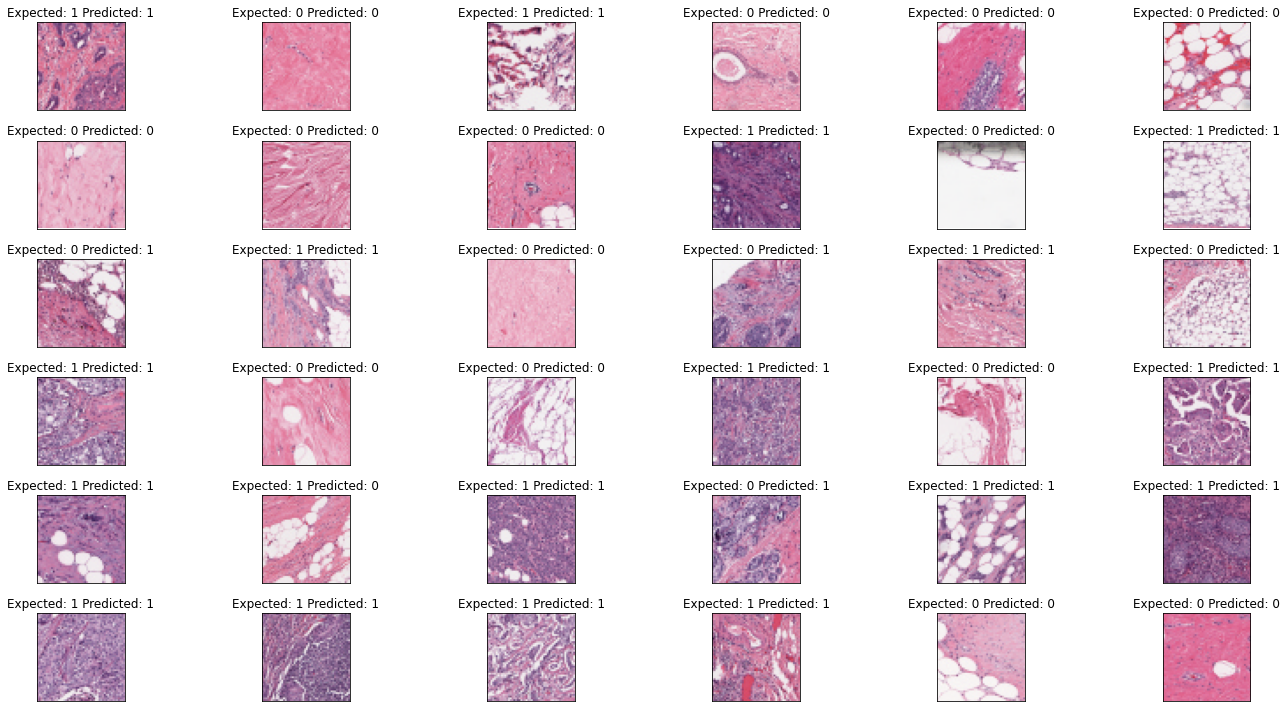

In [24]:
# Load a test image and visualize it
import cv2
import matplotlib.pyplot as plt
import math

def predict_random_samples(N):
    threshold = 0.5
    test_samples = test.sample(N)
    cols = math.floor(N ** 0.5)
    rows = math.ceil(N / cols) 
    fig, ax = plt.subplots(rows,cols,figsize=(20,10))

    counter = 0
    for index, test_sample in test_samples.iterrows():
        col = counter % cols
        row = counter // cols
        # Predicted the class of the image
        test_img = tf.keras.utils.load_img(test_sample['path'], target_size=(IMAGE_WIDTH, IMAGE_LENGTH))
        test_array = get_array_from_img(test_img)

        y_pred = model.predict(test_array, verbose = 0)
        predicted_class = np.where(y_pred > threshold, 1,0)[0][0]
        ax[row,col].imshow(test_img)
        ax[row,col].set_title(f'Expected: {test_sample["class"]} Predicted: {predicted_class}')
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)

        counter += 1
    fig.tight_layout()
    plt.show()

predict_random_samples(36)

## Prediction over a Large image


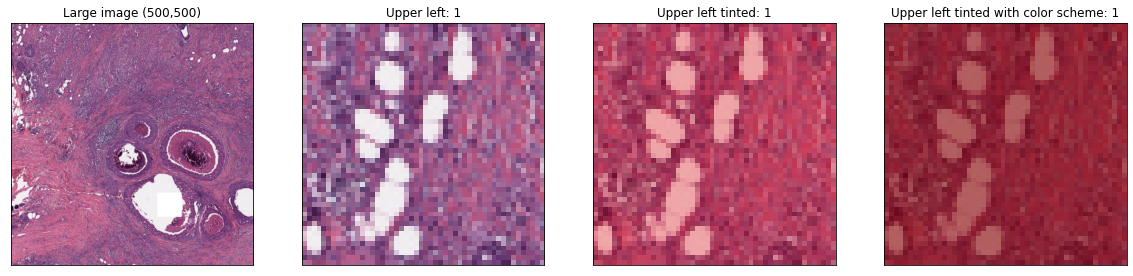

In [25]:
large_image_path = os.path.join("..", "..", "PreprocessedData", "Tiles(500, 500)", "8863", "12.png")

fig, ax = plt.subplots(1,4,figsize=(20,5))

# Show a large image
large_image = get_img(large_image_path)
ax[0].imshow(large_image)
ax[0].set_title(f'Large image (500,500)')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# Classify the upper left corner
ul = get_array_from_img(large_image)[0,:50,:50]
y_pred = model.predict(ul.reshape((1,50,50,3)), verbose = 0)
predicted_class = np.where(y_pred > 0.5, 1,0)[0][0]
ax[1].imshow(ul)
ax[1].set_title(f'Upper left: {predicted_class}')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# Tint the image according to the Predicted class 
import cv2
#https://stackoverflow.com/questions/46020894/superimpose-heatmap-on-a-base-image-opencv-python
mask = np.zeros((50,50,3)).astype('float32')
mask[:,:,0] = 1.0 * y_pred[0][0]
ul_tinted = cv2.addWeighted(mask, 0.3, ul, 0.7, 0)
plt.imshow(ul_tinted)

ax[2].imshow(ul_tinted)
ax[2].set_title(f'Upper left tinted: {predicted_class}')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

# Tint and use a colo scheme
mask = mask * 255
mask = mask.astype(np.uint8)
heatmap_img = cv2.applyColorMap(mask * 255, cv2.COLORMAP_JET)
ul_tinted_scheme = cv2.addWeighted(heatmap_img, 0.6, (ul*255).astype(np.uint8), 0.4, 0)

ax[3].imshow(ul_tinted_scheme)
ax[3].set_title(f'Upper left tinted with color scheme: {predicted_class}')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

In [26]:
#see https://stackoverflow.com/questions/46020894/superimpose-heatmap-on-a-base-image-opencv-python
#given a large image tint with a red color the zones with cancer 
def tint_image(path):
    input_image = get_img(path)
    img_array = get_array_from_img(input_image)
    PW = IMAGE_WIDTH
    PH = IMAGE_LENGTH
    mask = np.zeros(img_array[0].shape).astype('float32')
    for row in range(0,img_array[0].shape[0],PW):
        for col in range(0,img_array[0].shape[1],PH):
            patch = img_array[:,row:row+PH, col:col+PW, :]
            y_pred = model.predict(patch, verbose = 0)
            mask[row:row+PH, col:col+PW, 0] =  1 * y_pred[0][0]
            mask[row:row+PH, col:col+PW, 0] =  1 * y_pred[0][0]
            
    return cv2.addWeighted(mask, 0.5, img_array[0], 0.5, 0)

(-0.5, 499.5, 499.5, -0.5)

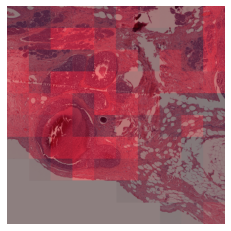

In [27]:
plt.imshow(tint_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "8863", "16.png")))
plt.axis('off')


## Using Grad-CAM

Code Adapted from https://keras.io/examples/vision/grad_cam/

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [31]:
# Read the summary and get the name of the last conv layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

1/1 [==============================] - 0s 27ms/step
Predicted: [[0.9078368]]


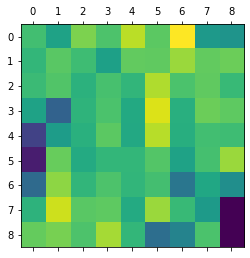

In [32]:
# Prepare image
img_path = test.sample(1)['path'].iloc[0]
img_array = keras.preprocessing.image.load_img(img_path, target_size=(50,50))
img_array = keras.preprocessing.image.img_to_array(img_array) / 255.0
img_array = np.expand_dims(img_array, axis=0)

last_conv_layer_name = "conv2d_2"

pred = model.predict(img_array)
print("Predicted:", pred)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = 0)

# Display heatmap
plt.matshow(heatmap)
plt.show()

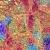

In [33]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet") #jet

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    #return superimposed_img


save_and_display_gradcam(img_path, heatmap)

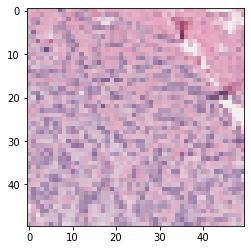

In [98]:
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

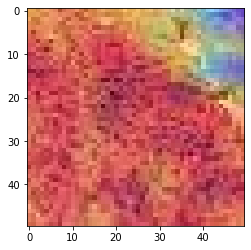

In [99]:
plt.imshow(cv2.cvtColor(cv2.imread("cam.jpg"), cv2.COLOR_BGR2RGB))

In [107]:
def get_img_array(img_path, size):
    img = tf.keras.utils.image.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img) / 255.0
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def gradcam(img, heatmap, alpha=0.7):
    img = img * 255.0
    img = img.astype(np.float32)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet") #jet
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1-alpha, jet_heatmap, alpha, 0) #jet_heatmap * alpha + img
    
    return superimposed_img / 255.0, jet_heatmap / 255.0

def tint_with_gradcam(path):
    input_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255.0
    PW = 50
    PH = 50
    output_image = np.zeros(input_image.shape)
    heatmap_image = np.zeros(input_image.shape)

    for col in range(0,input_image.shape[0],PW):
        for row in range(0,input_image.shape[1],PH):
            patch = input_image[row:row+PH, col:col+PW, :]
            y_pred = model.predict(patch.reshape((1,50,50,3)), verbose = 0)
            
            last_conv_layer_name = "conv2d_2"
            heatmap = make_gradcam_heatmap(patch.reshape((1,50,50,3)), model, last_conv_layer_name, pred_index = 0)
            out, heat = gradcam(patch, heatmap, alpha=0.3)
            output_image[row:row+PH, col:col+PW, :] =  out
            heatmap_image[row:row+PH, col:col+PW, :] = heat
    return output_image, heatmap_image





In [121]:
def predict_large_image(large_image_path):
    fig, ax = plt.subplots(1,3,figsize=(20,5))

    out, heat = tint_with_gradcam(large_image_path)

    # Show the original image
    ax[0].imshow(cv2.cvtColor(cv2.imread(large_image_path), cv2.COLOR_BGR2RGB))
    ax[0].set_title(f'Original image (500,500)')
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)

    # Show the Heatmap obtained from the last conv layer
    ax[1].imshow(heat)
    ax[1].set_title(f'Heatmap (500,500)')
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)


    # Show a large image
    ax[2].imshow(out)
    ax[2].set_title(f'Tinted image (500,500)')
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)    

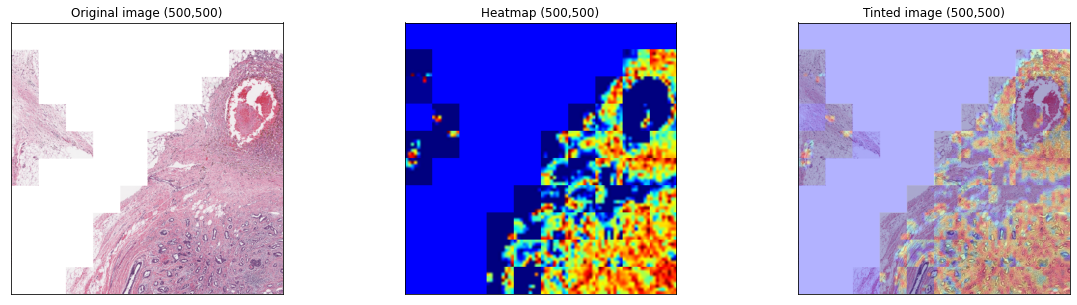

In [122]:
predict_large_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "8918", "19.png"))

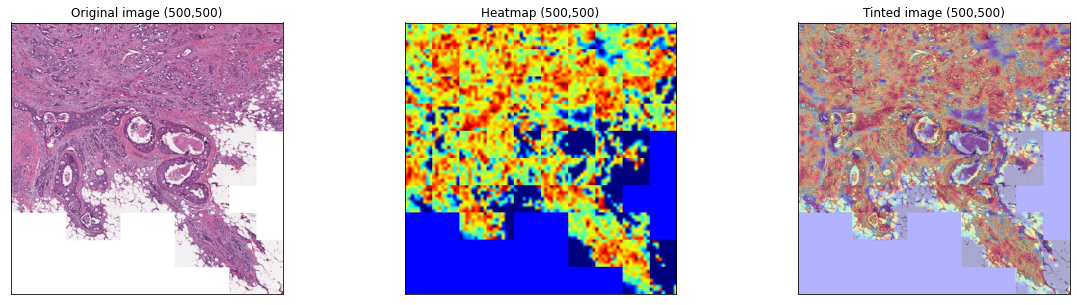

In [123]:
predict_large_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "10258", "12.png"))

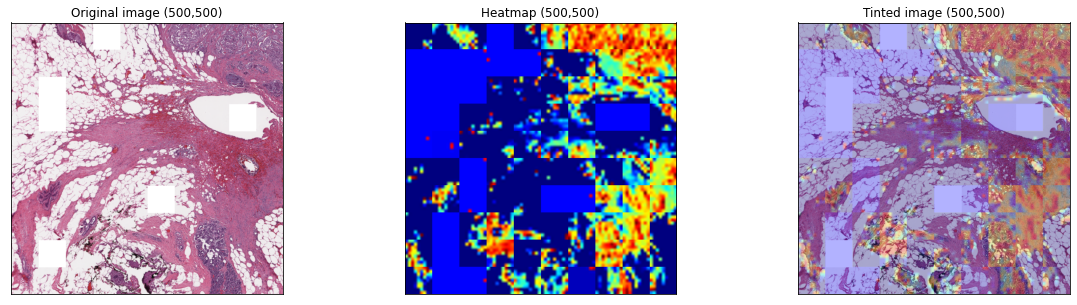

In [124]:
predict_large_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "9383", "13.png"))

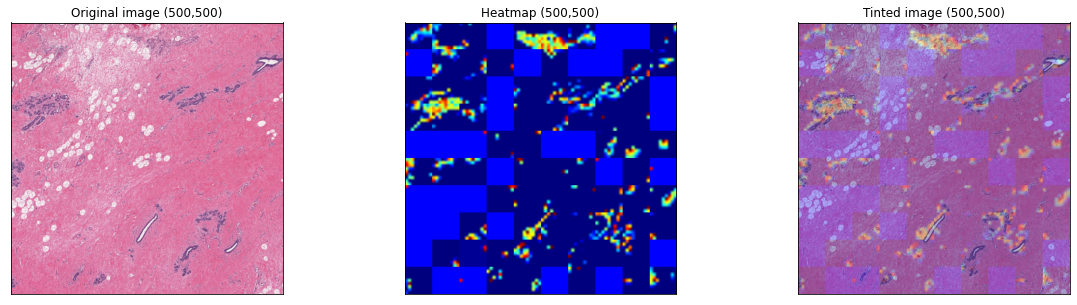

In [125]:
predict_large_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "10268", "15.png"))

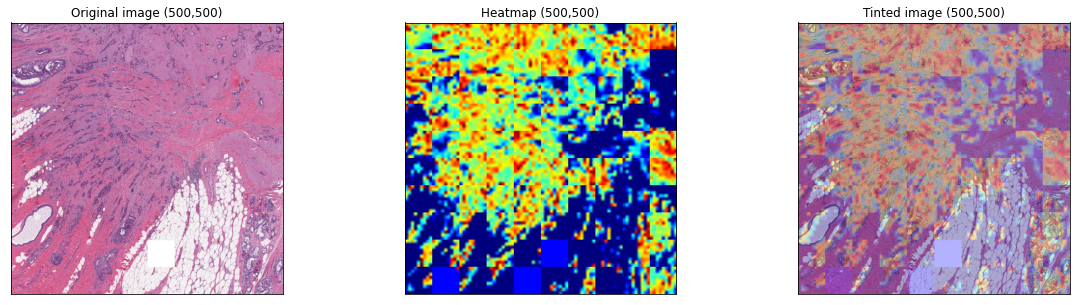

In [126]:
predict_large_image(os.path.join("..","..","PreprocessedData", "Tiles(500, 500)", "10278", "16.png"))